In [3]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

# Šis failas:
# /home/administratorius/git/python_kursai/DataScienceNotebooks/Studentai/MykolasOK/2024-11-11_užduotis_autop_atlyginimai.ipynb

# Duomenų šaltiniai:
# /home/administratorius/git/python_kursai/DataScienceNotebooks/DATA/atlyginimai.csv
# /home/administratorius/git/python_kursai/DataScienceNotebooks/DATA/WEBscr.db

In [4]:
# csv_df = pd.read_csv('../../DATA/atlyginimai.csv')
# print(df_csv.columns.tolist())

csv_df = pd.read_csv('../../DATA/atlyginimai.csv',usecols=['Sav.','Bruto, EUR', 'Neto, EUR'])

# trumpiausia_sav = csv_df['Sav.'].str.split(' ').str[0].apply(len).idxmin()
# print(csv_df['Sav.'].iloc[trumpiausia_sav]) # 'Kazlų Rūdos sav.'

# csv_df['miesto_k']=csv_df['Sav.'].str[:5].str.lower()

def savivaldybės_kodas(pavadinimas):
    plist=pavadinimas.split()
    sav_kodas=plist[0][:5]+'_'+plist[1][0]
    return sav_kodas.lower()

def miesto_kodas(pavadinimas):
    return pavadinimas[:4].lower()

csv_df['sav_k']=csv_df['Sav.'].apply(savivaldybės_kodas)
csv_df['miesto_k']=csv_df['Sav.'].apply(miesto_kodas)
csv_df['Atlyginimas']=csv_df['Neto, EUR'].str.replace(r'[^0-9.,]','',regex=True).str.replace(',','.').astype(float)

csv_df.head(5)

,Sav.,"Bruto, EUR","Neto, EUR",sav_k,miesto_k,Atlyginimas
0,Šalies ūkis,"2 000,1","1 241,2",šalie_ū,šali,1241.2
1,Akmenės r. sav.,"1 758,8","1 111,9",akmen_r,akme,1111.9
2,Alytaus m. sav.,"1 685,4","1 073,7",alyta_m,alyt,1073.7
3,Alytaus r. sav.,"1 528,5","991,9",alyta_r,alyt,991.9
4,Anykščių r. sav.,"1 537,7","996,7",anykš_r,anyk,996.7


In [5]:
conn = sqlite3.connect('../../DATA/WEBscr.db')
# query = "SELECT name FROM sqlite_master WHERE type='table';"
# print(pd.read_sql_query(query, conn)['name'].tolist())

query = "SELECT params FROM TUrl;" # SELECT id, params FROM TUrl;
db_df=pd.read_sql_query(query, conn)
# print(db_df.head(5))
df_autos = db_df['params'].str.split(';',expand=True)

df_autos.head(3)
# Kainos ir miestai ne savo stulpeliuose...

,0,1,2,3,4,5,6,7,8
0,-Kita- -kita-,2008-09,Krovininis mikroautobusas,Dyzelinas,Mechaninė,Utena,1 750 €,None,None
1,-Kita- -kita-,2011,Sedanas,Elektra,Automatinė,10 km,Jurbarkas,3 900 €,None
2,-Kita- -kita-,2020-02,Hečbekas,Elektra,Automatinė,29kW,14 000 km,Kėdainiai,6 800 €


In [6]:
# Funkcija, kuri paima pirmąjį stulpelį prieš stulpelį su € ženklu
def get_before_first_euro(row):
    # Patikrinti kiekvieną stulpelį eilutėje, ar jame yra €
    for index, value in enumerate(row.values):
        if '€' in str(value):
            return row.values[index-1]
    return None # Jei nėra reikšmės su €

# Funkcija, kuri paima paskutinįjį stulpelį, kuriame yra € ženklas
def get_last_euro(row):
    # Patikrinti kiekvieną stulpelį eilutėje, ar jame yra €
    for value in reversed(row.values):
        str_value=str(value).replace(' ','') # .replace('€','')
        if '€' in str_value:
            return int(str_value.split('€')[0])
    return None # Jei nėra reikšmės su €

# Sukuriame naują stulpelį su paskutine reikšme, kuriame yra €
df_autos['Miestas'] = df_autos.apply(get_before_first_euro,axis=1)
df_autos['Kaina'] = df_autos.apply(get_last_euro,axis=1)
df_autos['miesto_k']=df_autos['Miestas'].apply(miesto_kodas)

df_autos.head(3)
# Į savo stulpelius surenka ir kainas, ir miestus...

,0,1,2,3,4,5,6,7,8,Miestas,Kaina,miesto_k
0,-Kita- -kita-,2008-09,Krovininis mikroautobusas,Dyzelinas,Mechaninė,Utena,1 750 €,None,None,Utena,1750,uten
1,-Kita- -kita-,2011,Sedanas,Elektra,Automatinė,10 km,Jurbarkas,3 900 €,None,Jurbarkas,3900,jurb
2,-Kita- -kita-,2020-02,Hečbekas,Elektra,Automatinė,29kW,14 000 km,Kėdainiai,6 800 €,Kėdainiai,6800,kėda


In [7]:
df_autos_vid_kaina = df_autos.groupby('miesto_k')['Kaina'].mean()

df_sujungtas = pd.merge(df_autos_vid_kaina,csv_df,on='miesto_k',how='inner')[['Sav.','Kaina','Atlyginimas']]

df_sujungtas.head(3)

,Sav.,Kaina,Atlyginimas
0,Akmenės r. sav.,5888.727273,1111.9
1,Alytaus m. sav.,8516.674855,1073.7
2,Alytaus r. sav.,8516.674855,991.9


Kainos priklausomybė nuo atlyginimo (seaborn.regplot)


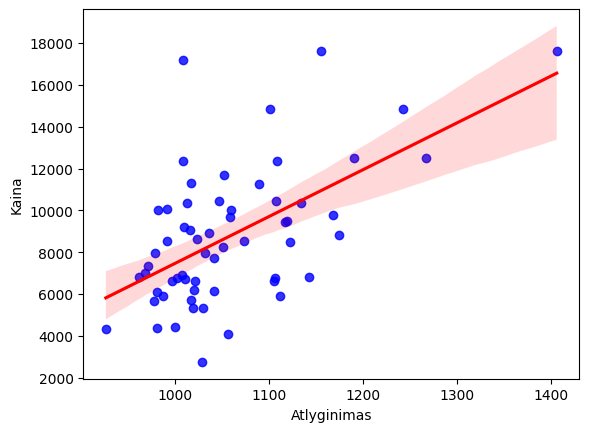

In [9]:
print('Kainos priklausomybė nuo atlyginimo (seaborn.regplot)')

axis=sns.regplot(data=df_sujungtas,x='Atlyginimas',y='Kaina',order=1,scatter_kws={"color":"blue"},line_kws={"color":"red"})
axis.set_xlim() # (0,5e5) 
axis.set_ylim() # (0,5e4)
plt.show()